In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from sklearn.ensemble import GradientBoostingRegressor as GBR
from functools import reduce
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fbprophet.plot import add_changepoints_to_plot
from arch import arch_model
from matplotlib import pyplot

In [2]:
crude=pd.read_csv("../data/Cushing, OK WTI Spot Price FOB (Dollars per Barrel).csv")
refiner=pd.read_csv('../data/U.S. Crude Oil Composite Acquisition Cost by Refiners (Dollars per Barrel).csv')
usd=pd.read_csv('../data/usd.csv')
pan=pd.read_csv('../data/Pandemics.csv')
stocks=pd.read_csv('../data/stocks.csv')

In [3]:
def clean(df,x):

    df.drop(['Apertura','Máximo','Mínimo','Vol.','% var.'],axis=1,inplace=True)

    df.rename(columns={'Fecha': 'Date', 'Cierre': x}, inplace=True)

    df['Date']=df.Date.apply(lambda x:x.replace('Ene','Jan'))
    df['Date']=df.Date.apply(lambda x:x.replace('Dic','Dec'))
    df['Date']=df.Date.apply(lambda x:x.replace('Abr','Apr'))
    df['Date']=df.Date.apply(lambda x:x.replace('Ago','Aug'))
    df['Date']=pd.to_datetime(df.Date)

    df.sort_values(by='Date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    df=df.set_index('Date')

In [4]:
clean(stocks,'Stocks_price_usd')

In [5]:
clean(usd,'usd')

In [6]:
def clean2(df,x):
    df.rename(columns={df.columns[1]: x}, inplace=True)
    df['Date']=pd.to_datetime(df.Date)
    df= df.set_index('Date')    

In [7]:
clean2(crude,'Crude_oil_price_usd')
clean2(refiner,'Refiners_Cost_usd')

In [8]:
pan=pan.fillna('non')
pan['Pandemics'] = np.where(pan['Pandemics']=='non',0,1)
pan['Date']=pd.to_datetime(pan.Date)
pan= pan.set_index('Date')

In [9]:
dfs= [crude,refiner,usd,stocks,pan]

In [10]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), dfs)

In [11]:
df_merged.drop(crude.tail(1).index,inplace=True)

In [12]:
df_merged=df_merged.set_index('Date')

In [13]:
df_merged.head()

,Crude_oil_price_usd,Refiners_Cost_usd,usd,Stocks_price_usd,Pandemics
Date,,,,,
1986-01-01,22.93,25.63,121.91,18.83,0.0
1986-02-01,15.46,19.76,115.15,13.26,0.0
1986-03-01,12.61,14.80,118.08,10.42,0.0
1986-04-01,12.84,13.05,112.62,13.34,0.0
1986-05-01,15.38,13.05,117.65,14.30,0.0


In [14]:
train, test = df_merged.Stocks_price_usd[:-10], df_merged.Stocks_price_usd[-10:]
modelo=SARIMAX(train, order=(20, 1, 5)).fit(disp=False)
                     
pred=modelo.predict(len(train), len(df_merged.Stocks_price_usd)-1)     
error=(pred-test).abs().sum()/len(pred) 
print ('Error mae: ', error)
res=pd.DataFrame({'real':test, 'pred':pred, 'diff':pred-test})
print('SARIMAX DF',res)

/home/david/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/david/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/david/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Error mae:  10.920777253616988
SARIMAX DF              real       pred       diff
2019-06-01  58.47  48.892064  -9.577936
2019-07-01  58.58  47.515085 -11.064915
2019-08-01  55.10  47.222992  -7.877008
2019-09-01  54.07  46.247151  -7.822849
2019-10-01  54.18  46.764773  -7.415227
2019-11-01  55.17  45.961516  -9.208484
2019-12-01  61.06  48.603875 -12.456125
2020-01-01  51.56  51.767867   0.207867
2020-02-01  44.76  54.567340   9.807340
2020-03-01  20.48  54.250024  33.770024


In [15]:
modelo=AR(train).fit()
pred=modelo.predict(len(train), len(df_merged.Stocks_price_usd)-1)

error=(pred-test).abs().sum()/len(pred)

print ('Error mae: ', error)

res=pd.DataFrame({'real':test, 'pred':pred, 'diff':pred-test})
print('AR DF',res)

Error mae:  10.4363222394238
AR DF              real       pred       diff
2019-06-01  58.47  49.457428  -9.012572
2019-07-01  58.58  48.941630  -9.638370
2019-08-01  55.10  48.724684  -6.375316
2019-09-01  54.07  46.544421  -7.525579
2019-10-01  54.18  47.052991  -7.127009
2019-11-01  55.17  47.074473  -8.095527
2019-12-01  61.06  49.685949 -11.374051
2020-01-01  51.56  52.434466   0.874466
2020-02-01  44.76  54.516382   9.756382
2020-03-01  20.48  55.063950  34.583950


/home/david/.local/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)


/home/david/.local/lib/python3.6/site-packages/st

In [16]:
dffinal=df_merged.copy()

In [17]:
df_arch=df_merged.copy()

In [18]:
df_merged.reset_index(level=0, inplace=True)

In [19]:
df_merged['Month']=df_merged.Date.dt.month
df_merged['Year']=df_merged.Date.dt.year
df_merged.drop(['Date'],axis=1,inplace=True)
X=df_merged.drop('Stocks_price_usd', axis=1)
y=df_merged.Stocks_price_usd
X_train, X_test, y_train, y_test=tts(X, y)

In [20]:
hyper={
    'n_estimators':hp.quniform('n_estimators', 10, 10000, 10),
    
    'learning_rate':hp.uniform('learning_rate', 0.0001, 1.0),
    
    'subsample':hp.uniform('x_subsample', 0.5, 1),
    
    'alpha':hp.uniform('x_alpha', 0.5, 0.9),
    
    'validation_fraction':hp.uniform('x_validation_fraction', 0.1, 0.4)
}

In [21]:
def goal(hyper):
    
    modelo=GBR(
        n_estimators=int(hyper['n_estimators']),
        learning_rate=hyper['learning_rate'],
        subsample=hyper['subsample'],
        alpha=hyper['alpha'],
        validation_fraction=hyper['validation_fraction']
    
    )
    
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    modelo.fit(X_train, y_train)
    
    y_pred=modelo.predict(X_test)
    
    rmse=mse(y_test, y_pred)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [22]:
trials_reg=Trials()

best=fmin(fn=goal, space=hyper, algo=tpe.suggest, max_evals=5, trials=Trials())

print('Best hyper-parameters',best)

100%|██████████| 5/5 [00:08<00:00,  1.70s/trial, best loss: 2.6337308551185568]
Best hyper-parameters {'learning_rate': 0.0039390605034923636, 'n_estimators': 2930.0, 'x_alpha': 0.7647397461936659, 'x_subsample': 0.8144842471018836, 'x_validation_fraction': 0.298669737527589}


In [23]:
modelo=GBR(
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    subsample= best['x_subsample'],
    alpha=best['x_alpha'],
    validation_fraction=best['x_validation_fraction'],
    )

In [24]:
modelo.fit(X_train, y_train)
y_pred=modelo.predict(X_test)
print('Mean square error',mse(y_test, y_pred))

Mean square error 6.9094826855907066


In [25]:
train_score=modelo.score(X_train, y_train) #R2
test_score=modelo.score(X_test, y_test)

print ('train R2:',train_score, '-- test R2:', test_score)

train R2: 0.9990406566771556 -- test R2: 0.991216330707088


In [26]:
pred=df_merged.drop('Stocks_price_usd', axis=1)

In [27]:
pred.head()

,Crude_oil_price_usd,Refiners_Cost_usd,usd,Pandemics,Month,Year
0,22.93,25.63,121.91,0.0,1,1986
1,15.46,19.76,115.15,0.0,2,1986
2,12.61,14.80,118.08,0.0,3,1986
3,12.84,13.05,112.62,0.0,4,1986
4,15.38,13.05,117.65,0.0,5,1986


In [28]:
res=modelo.predict(pred)


In [29]:
dffinal.drop(['Refiners_Cost_usd','usd','Stocks_price_usd','Pandemics'],axis=1,inplace=True)

In [30]:
dffinal.rename(columns={'Crude_oil_price_usd': 'Real'}, inplace=True)

In [31]:
dffinal['Predicitions']=res

In [32]:
dffinal['Difference']=dffinal.Predicitions-dffinal.Real

In [33]:
dffinal.head()

,Real,Predicitions,Difference
Date,,,
1986-01-01,22.93,19.741763,-3.188237
1986-02-01,15.46,13.825117,-1.634883
1986-03-01,12.61,11.040274,-1.569726
1986-04-01,12.84,12.561780,-0.278220
1986-05-01,15.38,14.696641,-0.683359


In [34]:
dfc=[dffinal,df_arch]

In [35]:
df_tab= reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), dfc)

In [36]:
df_tab.to_csv('Oil predictions.csv')

(192.0, 602.0)

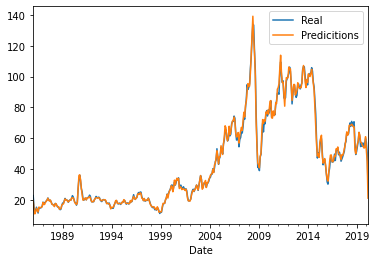

In [37]:
df=dffinal[['Real','Predicitions']]
subplot = df.plot()
subplot.set_xlim()

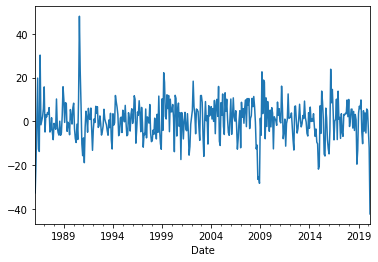

In [38]:
data = df_arch
market = df_arch['Crude_oil_price_usd']
returns = 100 * market.pct_change().dropna()
ax = returns.plot()
xlim = ax.set_xlim(returns.index.min(), returns.index.max())

In [39]:
am = arch_model(returns)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1447.043491486425
Iteration:     10,   Func. Count:     65,   Neg. LLF: 1446.6992919007416
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1446.6992689430015
            Iterations: 11
            Function evaluations: 72
            Gradient evaluations: 11
                      Constant Mean - GARCH Model Results                      
Dep. Variable:     Crude_oil_price_usd   R-squared:                      -0.002
Mean Model:              Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                       GARCH   Log-Likelihood:               -1446.70
Distribution:                   Normal   AIC:                           2901.40
Method:             Maximum Likelihood   BIC:                           2917.46
                                         No. Observations:                  410
Date:                 Wed, May 20 2020   Df Residuals:                      406
Time

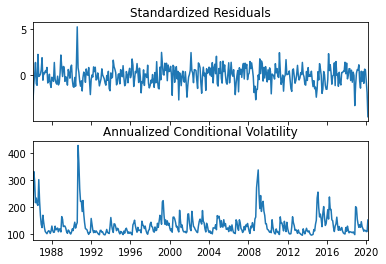

In [40]:
fig = res.plot(annualize='D')

In [41]:
am = arch_model(returns, p=1, o=1, q=1)
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:     Crude_oil_price_usd   R-squared:                      -0.000
Mean Model:              Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                   GJR-GARCH   Log-Likelihood:               -1442.08
Distribution:                   Normal   AIC:                           2894.15
Method:             Maximum Likelihood   BIC:                           2914.23
                                         No. Observations:                  410
Date:                 Wed, May 20 2020   Df Residuals:                      405
Time:                         03:27:02   Df Model:                            5
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.6547      0.391      1.673  9.438e-02 [ -0.1

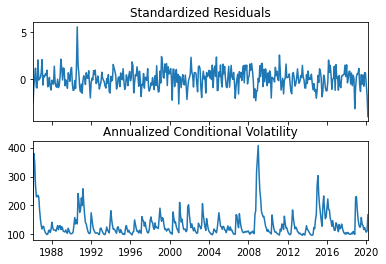

In [42]:
fig = res.plot(annualize='D')

In [43]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     42,   Neg. LLF: 1445.0589257136326
Iteration:     10,   Func. Count:     81,   Neg. LLF: 1443.8057764950754
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1443.7973156515586
            Iterations: 13
            Function evaluations: 102
            Gradient evaluations: 13
                   Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:     Crude_oil_price_usd   R-squared:                      -0.000
Mean Model:              Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                 TARCH/ZARCH   Log-Likelihood:               -1443.80
Distribution:                   Normal   AIC:                           2897.59
Method:             Maximum Likelihood   BIC:                           2917.68
                                         No. Observations:                  410
Date:                 Wed, May 20 2020   Df Residuals:                      405
Ti

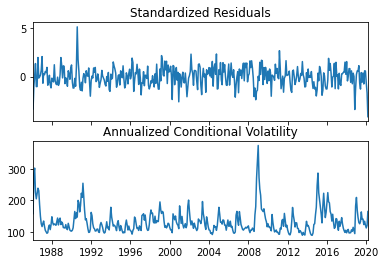

In [44]:
fig = res.plot(annualize='D')

In [45]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     46,   Neg. LLF: 1437.7819471778112
Iteration:     10,   Func. Count:     90,   Neg. LLF: 1436.631296268387
Iteration:     15,   Func. Count:    131,   Neg. LLF: 1436.5049760898876
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1436.5049697793474
            Iterations: 16
            Function evaluations: 139
            Gradient evaluations: 16
                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:          Crude_oil_price_usd   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -1436.50
Distribution:      Standardized Student's t   AIC:                           2885.01
Method:                  Maximum Likelihood   BIC:                           2909.11
                                              No. Observatio

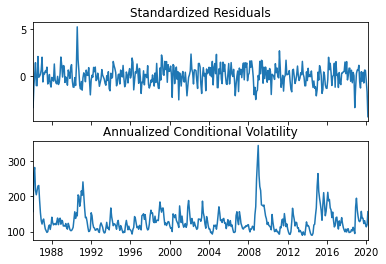

In [46]:
fig = res.plot(annualize='D')

In [47]:
fixed_res = am.fix([0.0235, 0.01, 0.06, 0.0, 0.9382, 8.0])
print(fixed_res.summary())

                      Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:           Crude_oil_price_usd   R-squared:                          --
Mean Model:                    Constant Mean   Adj. R-squared:                     --
Vol Model:                       TARCH/ZARCH   Log-Likelihood:               -1478.62
Distribution:       Standardized Student's t   AIC:                           2969.23
Method:            User-specified Parameters   BIC:                           2993.33
                                               No. Observations:                  410
Date:                       Wed, May 20 2020                                         
Time:                               03:27:03                                         
      Mean Model     
                 coef
---------------------
mu             0.0235
   Volatility Model  
                 coef
---------------------
omega          0.0100
alpha[1]       0.0600
gamma[1]       0.0000
beta[1

(193.0, 602.0)

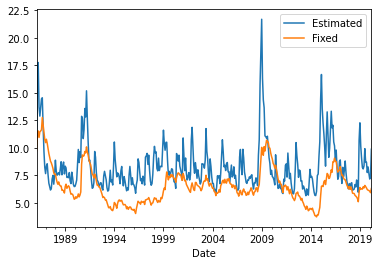

In [48]:
df = pd.concat([res.conditional_volatility, fixed_res.conditional_volatility],
               1)
df.columns = ['Estimated', 'Fixed']
subplot = df.plot()
subplot.set_xlim(xlim)

In [49]:
data=data.Stocks_price_usd

In [50]:
res = arch_model(data, p=1, o=1, q=1, dist='skewt').fit(disp='off')
pd.DataFrame(res.params)

,params
mu,17.385631
omega,5.541651
alpha[1],1.000000
gamma[1],-0.974196
beta[1],0.437216
nu,3.539332
lambda,-0.817420


In [51]:
sim_mod = arch_model(None, p=1, o=1, q=1, dist="skewt")

sim_data = sim_mod.simulate(res.params, 1000)
sim_data.head()

,data,volatility,errors
0,20.065194,3.903377,2.679563
1,9.941495,4.402645,-7.444136
2,10.600995,3.930174,-6.784637
3,19.078382,3.671893,1.692751
4,18.522322,3.781792,1.136690


In [52]:
sim_data.describe()

,data,volatility,errors
count,1000.000000,1000.000000,1000.000000
mean,17.456112,4.102052,0.070480
std,3.925752,1.000533,3.925752
min,-31.958329,3.150685,-49.343961
25%,16.065974,3.470413,-1.319658
50%,18.308524,3.834270,0.922893
75%,19.861873,4.454908,2.476241
max,28.325104,14.146418,10.939473


In [53]:
dffinal.describe()

,Real,Predicitions,Difference
count,411.000000,411.000000,411.000000
mean,44.189270,44.290160,0.100890
std,29.059914,29.198397,1.734189
min,11.350000,11.040274,-8.676249
25%,19.760000,19.773863,-0.422362
50%,31.260000,32.610319,0.037135
75%,63.095000,64.406012,0.686797
max,133.880000,139.100295,6.709638


In [54]:
df_arch.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 411 entries, 1986-01-01 to 2020-03-01
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Crude_oil_price_usd  411 non-null    float64
 1   Refiners_Cost_usd    411 non-null    float64
 2   usd                  411 non-null    float64
 3   Stocks_price_usd     411 non-null    float64
 4   Pandemics            411 non-null    float64
dtypes: float64(5)
memory usage: 19.3 KB


In [55]:
df_arch.drop(df_arch.index[:200],inplace=True)

In [56]:
df_arch.head()

,Crude_oil_price_usd,Refiners_Cost_usd,usd,Stocks_price_usd,Pandemics
Date,,,,,
2002-09-01,29.66,27.66,107.26,30.45,0.0
2002-10-01,28.84,26.70,106.82,27.22,0.0
2002-11-01,26.35,24.60,106.50,26.89,1.0
2002-12-01,29.46,26.93,102.26,31.20,1.0
2003-01-01,32.95,30.52,100.14,33.51,1.0


In [57]:
def features(df, label):
    df=df.copy()
    df['date']=df.index
    df['quarter']=df.date.dt.quarter
    df['month']=df.date.dt.month
    df['year']=df.date.dt.year
    df['week_of_year']=df.date.dt.weekofyear
    
    X=df[[ 'quarter', 'month', 'year',
           'week_of_year']]
    y=df[label]
    
    return X,y

In [58]:
X, y = features(df_arch, 'Stocks_price_usd')
data=pd.concat([X, y], axis=1)
data.head()

,quarter,month,year,week_of_year,Stocks_price_usd
Date,,,,,
2002-09-01,3,9,2002,35,30.45
2002-10-01,4,10,2002,40,27.22
2002-11-01,4,11,2002,44,26.89
2002-12-01,4,12,2002,48,31.20
2003-01-01,1,1,2003,1,33.51


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


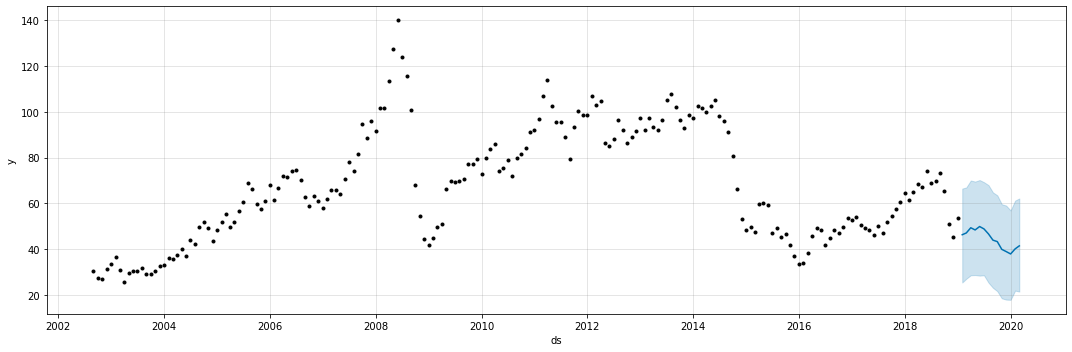

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
split_date='01-Jan-2019'

train=df_arch.loc[df_arch.index<=split_date].copy()
test=df_arch.loc[df_arch.index>split_date].copy()
train=train.reset_index().rename(columns={'Date':'ds', 'Stocks_price_usd':'y'})
test=test.reset_index().rename(columns={'Date':'ds', 'Stocks_price_usd':'y'})
train.head()
m=Prophet().fit(train)

forecast=m.predict(test)
f, ax=plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig=m.plot(forecast, ax=ax)

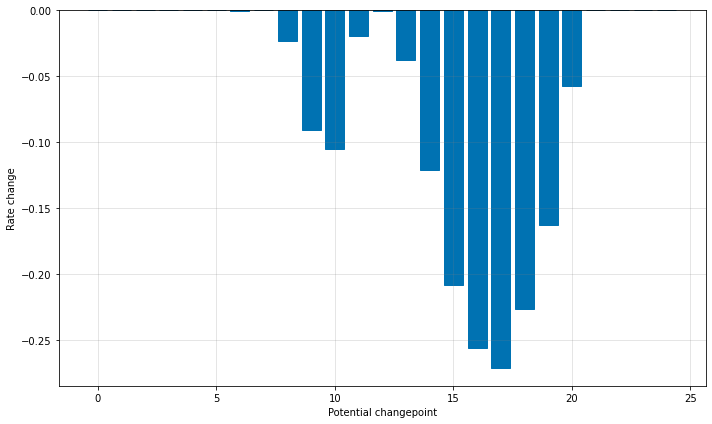

In [60]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

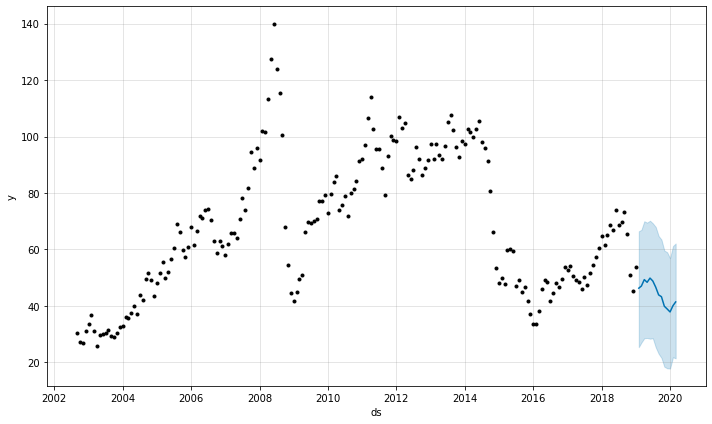

In [61]:
ig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


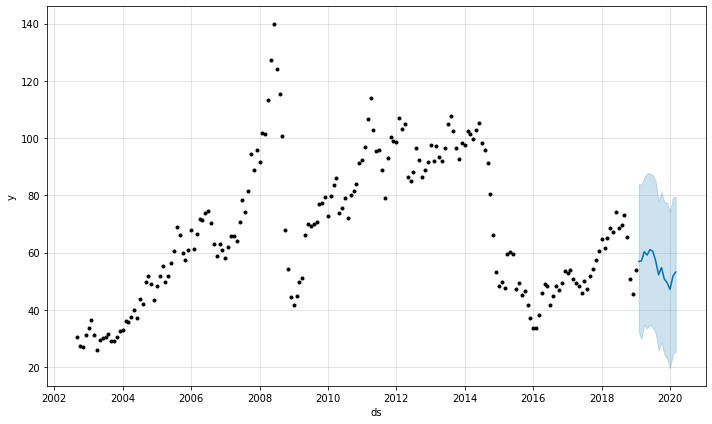

In [62]:
m = Prophet(changepoints=['01-Dec-2014'])
forecast = m.fit(train).predict(test)
fig = m.plot(forecast)

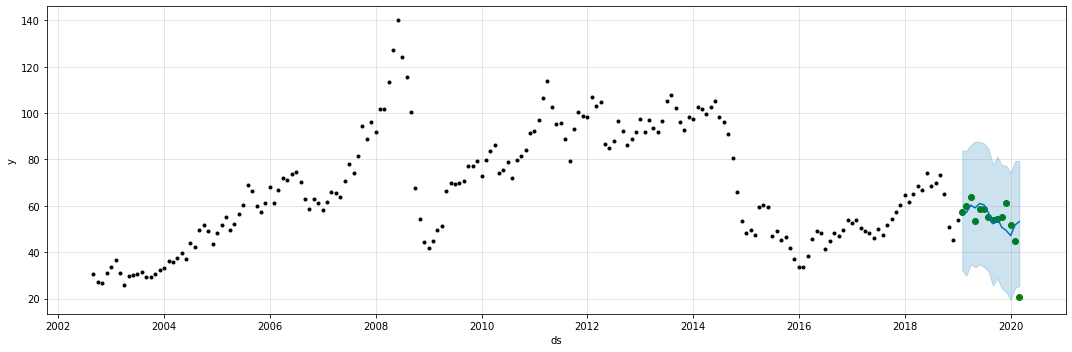

In [63]:
f, ax=plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.ds, test.y, color='g')
fig=m.plot(forecast, ax)

In [80]:
dffinal.tail()

,Real,Predicitions,Difference
Date,,,
2019-11-01,57.03,53.872767,-3.157233
2019-12-01,59.88,61.065622,1.185622
2020-01-01,57.52,52.130249,-5.389751
2020-02-01,50.54,45.026128,-5.513872
2020-03-01,29.21,21.259842,-7.950158


In [65]:
preds=pd.read_csv('../data/preds.csv')

In [66]:
preds.head()

,Fecha,Cierre,Apertura,Máximo,Mínimo,Vol.,% var.
0,May 2020,31.70,19.56,33.07,18.05,36.07K,62.07%
1,Abr 2020,19.56,20.30,29.12,6.55,6.30M,-4.49%
2,Mar 2020,20.48,43.70,48.66,19.27,16.68M,-54.24%


In [67]:
clean(preds,'Futuro')

In [68]:
preds.head()

,Date,Futuro
0,2020-03-01,20.48
1,2020-04-01,19.56
2,2020-05-01,31.70


In [69]:
preds.insert(1, "Refiners_Cost_usd", [32.72, 25.80, 29.1], True)
preds.insert(2, "usd", [99.92, 99.028, 99.48], True)
preds.insert(3, "Pandemics", [1, 1, 1], True)

In [70]:
preds.insert(0, "Crude_oil_price_usd", [29.21, 15.10, 26.5], True)
preds.insert(4, "Month", [3, 4, 5], True)
preds.insert(5, "Year", [2020, 2020, 2020], True)

In [71]:
df2 = pd.DataFrame({"Crude_oil_price_usd":[28.4,30.7,32.9,34.5,37.1,38.1,38.5,37.1,38.3], 
                    "Refiners_Cost_usd":[31.4,32.7,34.9,36.5,39.1,40.1,38.5,38.1,40.3],
                    "usd":[99.4,99.62,99.51,99.6,99.5,99.85,99.53,99.62,99.81],
                    "Month":[6,7,8,9,10,11,12,1,2],
                    "Year":[2020,2020,2020,2020,2020,2020,2020,2021,2021],
                    "Pandemics":[1,1,1,1,1,1,1,1,1],}) 

In [72]:
preds.drop('Date',axis=1,inplace=True)
preds.head()

,Crude_oil_price_usd,Refiners_Cost_usd,usd,Month,Year,Pandemics,Futuro
0,29.21,32.72,99.920,3,2020,1,20.48
1,15.10,25.80,99.028,4,2020,1,19.56
2,26.50,29.10,99.480,5,2020,1,31.70


In [73]:
df2.head()

,Crude_oil_price_usd,Refiners_Cost_usd,usd,Month,Year,Pandemics
0,28.4,31.4,99.40,6,2020,1
1,30.7,32.7,99.62,7,2020,1
2,32.9,34.9,99.51,8,2020,1
3,34.5,36.5,99.60,9,2020,1
4,37.1,39.1,99.50,10,2020,1


In [74]:
preds=preds.append(df2, ignore_index = True)

In [75]:
preds.head()

,Crude_oil_price_usd,Refiners_Cost_usd,usd,Month,Year,Pandemics,Futuro
0,29.21,32.72,99.920,3,2020,1,20.48
1,15.10,25.80,99.028,4,2020,1,19.56
2,26.50,29.10,99.480,5,2020,1,31.70
3,28.40,31.40,99.400,6,2020,1,NaN
4,30.70,32.70,99.620,7,2020,1,NaN


In [76]:
futuro=preds.Futuro
preds.drop('Futuro',axis=1,inplace=True)

In [77]:
res=modelo.predict(preds)

In [78]:
preds['Predicitions']=res
preds['Real']=futuro
preds.head()

,Crude_oil_price_usd,Refiners_Cost_usd,usd,Month,Year,Pandemics,Predicitions,Real
0,29.21,32.72,99.920,3,2020,1,28.188251,20.48
1,15.10,25.80,99.028,4,2020,1,15.780648,19.56
2,26.50,29.10,99.480,5,2020,1,27.081335,31.70
3,28.40,31.40,99.400,6,2020,1,27.951528,NaN
4,30.70,32.70,99.620,7,2020,1,31.412651,NaN


In [79]:
preds

,Crude_oil_price_usd,Refiners_Cost_usd,usd,Month,Year,Pandemics,Predicitions,Real
0,29.21,32.72,99.920,3,2020,1,28.188251,20.48
1,15.10,25.80,99.028,4,2020,1,15.780648,19.56
2,26.50,29.10,99.480,5,2020,1,27.081335,31.70
3,28.40,31.40,99.400,6,2020,1,27.951528,NaN
4,30.70,32.70,99.620,7,2020,1,31.412651,NaN
5,32.90,34.90,99.510,8,2020,1,33.566328,NaN
6,34.50,36.50,99.600,9,2020,1,36.971293,NaN
7,37.10,39.10,99.500,10,2020,1,39.932676,NaN
8,38.10,40.10,99.850,11,2020,1,40.485511,NaN
9,38.50,38.50,99.530,12,2020,1,40.305452,NaN


In [81]:
preds.to_csv('One year prediction.csv')